RQ4 - How prevalent are code smells in Dockerfiles?
==============

# Dependencies and Configurations

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import itertools
from datetime import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.ticker as ticker
import psycopg2
import os
import re
import subprocess
import json
from pandarallel import pandarallel

### Dependency: Haskell Dockerfile Linter (Hadolint)
* Haskell Dockerfile Linter (Hadolint) is required to reproduce this RQ.
* Haskell Dockerfile Linter (Hadolint) Installation Instructions: https://github.com/hadolint/hadolint

## Database Configurations

In [2]:
POSTGRESQL_USER = os.getenv('POSTGRESQL_USER') if os.getenv('POSTGRESQL_USER') is not None else 'dockerstudy'
POSTGRESQL_PASSWORD = os.getenv('POSTGRESQL_PASSWORD') if os.getenv('POSTGRESQL_PASSWORD') is not None else 'dockerstudy'
POSTGRESQL_HOST_IP = os.getenv('POSTGRESQL_HOST_IP') if os.getenv('POSTGRESQL_HOST_IP') is not None else 'localhost'
POSTGRESQL_PORT = os.getenv('POSTGRESQL_PORT') if os.getenv('POSTGRESQL_PORT') is not None else '5432'
POSTGRESQL_DATABASE = os.getenv('POSTGRESQL_DATABASE') if os.getenv('POSTGRESQL_DATABASE') is not None else 'dockerstudy'

## Load the relevant tables

In [3]:
conn = psycopg2.connect(database=POSTGRESQL_DATABASE, user=POSTGRESQL_USER, password=POSTGRESQL_PASSWORD, host=POSTGRESQL_HOST_IP, port=POSTGRESQL_PORT)
Dockerfiles = pd.read_sql_query('select * from public.dockerfile order by dockerfile_id asc', con = conn)
Images = pd.read_sql_query('select * from public.image', con = conn)
conn.close()

# Smells in Dockerfiles

In [5]:
# Function for using hadolint AST to analyze Dockerfile
def hadolint(x):
    file_id = str(x['dockerfile_id'])
    file_name = 'Dockerfile_' + file_id
    with open(file_name, 'w') as file:
        file.write(x['content'])
    proc_hadolint = subprocess.Popen(['hadolint', '-f', 'json', file_name],
                                   stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    hadolint_result = proc_hadolint.communicate()[0].decode('utf-8')
    os.remove(file_name)
    try:
        results = json.loads(hadolint_result)
    except:
        results = []
    return results

In [6]:
pandarallel.initialize()
Dockerfiles['smells'] = Dockerfiles.parallel_apply(hadolint, axis=1)
Dockerfiles_ast_results = Dockerfiles.copy()

In [8]:
pandarallel.initialize()
Dockerfiles_ast_results['smell_count'] = Dockerfiles_ast_results['smells'].parallel_apply(lambda x: len(x))
Dockerfiles_ast_results['update_year'] = Dockerfiles_ast_results['committer_committed_at'].parallel_apply(lambda x: x.year if x is not None else None)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [9]:
Dockerfiles_ast_results = Dockerfiles_ast_results[Dockerfiles_ast_results['content']!='404: Not Found']
Dockerfiles_ast_results = Dockerfiles_ast_results.sort_values(by='committer_committed_at', ascending=False)
Dockerfiles_ast_results_trending_analysis = Dockerfiles_ast_results.groupby(by=['dockerfile_id','update_year'], as_index=False).mean()
Dockerfiles_ast_results_trending_analysis = Dockerfiles_ast_results_trending_analysis.dropna()

In [10]:
print('Average smell count: ', np.mean(Dockerfiles_ast_results_trending_analysis['smell_count']))
print('Meidan smell count: ', np.median(Dockerfiles_ast_results_trending_analysis['smell_count']))
print('25th quantile of smell count: ', np.quantile(Dockerfiles_ast_results_trending_analysis['smell_count'], q=0.25))
print('75th quantile of smell count: ', np.quantile(Dockerfiles_ast_results_trending_analysis['smell_count'], q=0.75))
print('The proportion of smell-free Dockerfiles: ', Dockerfiles_ast_results_trending_analysis[Dockerfiles_ast_results_trending_analysis['smell_count']==0].shape[0]/Dockerfiles_ast_results_trending_analysis.shape[0])

Average smell count:  5.133314785546983
Meidan smell count:  4.0
25th quantile of smell count:  2.0
75th quantile of smell count:  6.0
The proportion of smell-free Dockerfiles:  0.07775654062151398


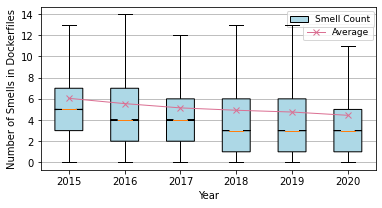

Average Number of Smells in Dockerfiles in 2015: 6.0489498233977725
Average Number of Smells in Dockerfiles in 2016: 5.550146148399629
Average Number of Smells in Dockerfiles in 2017: 5.146727813449755
Average Number of Smells in Dockerfiles in 2018: 4.923251332887598
Average Number of Smells in Dockerfiles in 2019: 4.755289685253916
Average Number of Smells in Dockerfiles in 2020: 4.4460546353155905


In [12]:
smell_count_in_year = [Dockerfiles_ast_results_trending_analysis[Dockerfiles_ast_results_trending_analysis['update_year']==year]['smell_count'].values for year in list(range(2015, 2021))]
labels = list(range(2015, 2021))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
position_list = list(range(0, len(labels)))
bplot = ax.boxplot(smell_count_in_year,
                         notch=True,
                         vert=True,
                         patch_artist=True,
                         showfliers=False,
                         positions=position_list,
                         labels=labels, zorder=10)

avg_count_line = ax.plot(position_list,  [np.mean(Dockerfiles_ast_results_trending_analysis[Dockerfiles_ast_results_trending_analysis['update_year']==year]['smell_count'].values) for year in range(2015, 2021)], linewidth=1, color='palevioletred', marker='x', markeredgecolor='palevioletred', zorder=20, label='Average')

for patch in bplot['boxes']:
    patch.set_facecolor('lightblue')
    
ax.yaxis.grid(True)
ax_legend1 = ax.legend(loc='upper left', bbox_to_anchor=(0.77,0.92),  prop={'size': 9})
ax_legend = ax.legend([bplot["boxes"][0]], ['Smell Count'], loc='upper left', bbox_to_anchor=(0.72,1.0),  prop={'size': 9})
ax.add_artist(ax_legend1)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Smells in Dockerfiles')
plt.show()
fig.tight_layout()
fig.savefig('Smell_Count', dpi=300)
fig.savefig('Smell_Count.pdf')
for year in range(2015, 2021):
    print('Average Number of Smells in Dockerfiles in {}: {}'.format(year, np.mean(Dockerfiles_ast_results_trending_analysis[Dockerfiles_ast_results_trending_analysis['update_year']==year]['smell_count'].values)))

In [13]:
pull_count_gte1000_image_name = Images[Images['pull_count']>=1000]['image_name']
Dockerfiles_ast_results = Dockerfiles_ast_results[Dockerfiles_ast_results['image_name'].isin(pull_count_gte1000_image_name)].copy()

In [14]:
Dockerfiles_ast_results = Dockerfiles_ast_results.sort_values(by='committer_committed_at', ascending=False)
Dockerfiles_prevalent_smells = Dockerfiles_ast_results.drop_duplicates(subset=['path', 'repo_id', 'update_year'], keep='first').copy()
pandarallel.initialize()
Dockerfiles_prevalent_smells['smell_code'] = Dockerfiles_prevalent_smells['smells'].parallel_apply(lambda x: [item['code'] for item in x] if x is not None else [])
Dockerfiles_prevalent_smells = Dockerfiles_prevalent_smells.dropna(subset=['smell_code', 'update_year'])
Dockerfiles_prevalent_smells.index = range(0, Dockerfiles_prevalent_smells.shape[0])
Dockerfiles_prevalent_smells = Dockerfiles_prevalent_smells.explode('smell_code')[['update_year', 'smell_code']]
Dockerfiles_prevalent_smells.index = range(0, Dockerfiles_prevalent_smells.shape[0])

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [15]:
print('Top 15 Most Prevalent Smells in Dockerfiles') # In terms of overall proportion
Dockerfiles_prevalent_smells['smell_code'].value_counts()[:15]/Dockerfiles_prevalent_smells['smell_code'].shape[0]*100

Top 15 Most Prevalent Smells in Dockerfiles


DL3008    13.359891
DL3015     9.514359
DL3020     9.043765
DL4006     8.308808
DL4000     7.652575
DL3003     6.966404
DL3018     6.574692
DL3009     5.640790
DL3006     3.303977
DL3013     2.850490
SC2086     2.438503
DL3025     2.325883
DL3019     2.214690
DL3007     1.898215
SC2046     1.574454
Name: smell_code, dtype: float64

In [16]:
# Over time
year_list=range(2015,2021)
all_smell_trend=pd.DataFrame(columns=['Year','Smell','Proportion'])
for year in year_list:
    current_year_smell=Dockerfiles_prevalent_smells.query("update_year=={}".format(year)).dropna()['smell_code']
    smell_proportion=current_year_smell.value_counts()/len(current_year_smell)*100.0
    for i in range(smell_proportion.size):
        all_smell_trend=all_smell_trend.append(pd.DataFrame([[year,smell_proportion.index[i],smell_proportion[i]]],columns=['Year','Smell','Proportion']),ignore_index=True)


smell_trend=pd.DataFrame(columns=['Year','Smell','Proportion'])
for year in year_list:
    current_year_smell=Dockerfiles_prevalent_smells.query("update_year=={}".format(year)).dropna()['smell_code']
    smell_proportion=current_year_smell.value_counts()/len(current_year_smell)*100.0
    for i in range(10):
        try:
            smell_trend=smell_trend.append(pd.DataFrame([[year,smell_proportion.index[i],smell_proportion[i]]],columns=['Year','Smell','Proportion']),ignore_index=True)
        except:
            continue
smlt=smell_trend['Smell'].drop_duplicates()
smlt.index=range(0,smlt.size)
for year in year_list:
    for i in range(0,smlt.size):
        dt=smell_trend.query("Year=={} and Smell=='{}'".format(year,smlt[i]))
        if(dt.shape[0]==0):
            try:
                prop=all_smell_trend.query("Year=={} and Smell=='{}'".format(year,smlt[i]))['Proportion']
                prop=prop[prop.index[0]]
            except:
                prop=0
            smell_trend=smell_trend.append(pd.DataFrame([[year,smlt[i],prop]],columns=['Year','Smell','Proportion']),ignore_index=True)

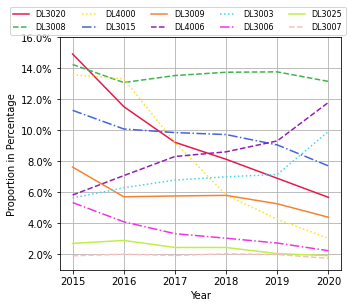

In [30]:
colors_list = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabebe', '#469990', '#e6beff', '#9A6324', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9']
linestyles = ['-', '--', '-.', ':']
from cycler import cycler
plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
fig=plt.figure(figsize=(5,4.4))
ax=plt.subplot(111)
ax.grid()
ax.set_ylim(1,16)
for i in range(0,10):
    ax.plot(year_list, smell_trend[smell_trend['Smell']==smlt[i]].sort_values(by=['Year'])['Proportion'], label=smlt[i], color=colors_list[i]) 
ax.legend(loc='upper right', bbox_to_anchor=(1.03, 1.15),  prop={'size': 8} ,ncol=5)
ax.set_xlabel('Year')
ax.set_ylabel('Proportion in Percentage')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
plt.tight_layout()
fig.savefig('popular-smells-over-time', dpi=300)
fig.savefig('popular-smells-over-time.pdf')